## Data Loading and Pre-Processing

Import necessary packages and libraries

In [42]:
!pip install category_encoders

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import re
import geopandas as gpd
from sklearn.model_selection import train_test_split
from category_encoders import TargetEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from joblib import dump

pd.set_option("future.no_silent_downcasting", True) # Prevent silent data type changes during operations for future compatibility

Load the <a href="https://www.kaggle.com/datasets/amitzala/us-airline-flight-routes-and-fares?select=US+Airline+Flight+Routes+and+Fares.csv">US Airline Flight Routes and Fares dataset</a> into a dataframe

In [10]:
df = pd.read_csv("../data/US Airline Flight Routes and Fares 1993-2024.csv")
display(df.head())
print(df.shape)

/var/folders/zl/qsjwzr3127l4jqknpgwg1q580000gn/T/ipykernel_23880/3447968871.py:1: DtypeWarning: Columns (20,21) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("../data/US Airline Flight Routes and Fares 1993-2024.csv")


,tbl,Year,quarter,citymarketid_1,citymarketid_2,city1,city2,airportid_1,airportid_2,airport_1,...,fare,carrier_lg,large_ms,fare_lg,carrier_low,lf_ms,fare_low,Geocoded_City1,Geocoded_City2,tbl1apk
0,Table1a,2021,3,30135,33195,"Allentown/Bethlehem/Easton, PA","Tampa, FL (Metropolitan Area)",10135,14112,ABE,...,81.43,G4,1.0000,81.43,G4,1.0000,81.43,NaN,NaN,202131013514112ABEPIE
1,Table1a,2021,3,30135,33195,"Allentown/Bethlehem/Easton, PA","Tampa, FL (Metropolitan Area)",10135,15304,ABE,...,208.93,DL,0.4659,219.98,UA,0.1193,154.11,NaN,NaN,202131013515304ABETPA
2,Table1a,2021,3,30140,30194,"Albuquerque, NM","Dallas/Fort Worth, TX",10140,11259,ABQ,...,184.56,WN,0.9968,184.44,WN,0.9968,184.44,NaN,NaN,202131014011259ABQDAL
3,Table1a,2021,3,30140,30194,"Albuquerque, NM","Dallas/Fort Worth, TX",10140,11298,ABQ,...,182.64,AA,0.9774,183.09,AA,0.9774,183.09,NaN,NaN,202131014011298ABQDFW
4,Table1a,2021,3,30140,30466,"Albuquerque, NM","Phoenix, AZ",10140,14107,ABQ,...,177.11,WN,0.6061,184.49,AA,0.3939,165.77,NaN,NaN,202131014014107ABQPHX


(245955, 23)


Upon loading the dataframe, we immediately observe issues with it. There is a warning message above saying `DtypeWarning: Columns (20,21) have mixed types. Specify dtype option on import or set low_memory=False.` To address this, we identify what these columns are and address this problem if needed.

In [45]:
print("Columns with mixed types:")
for col in df.columns[20:22]:
  print(col)

Columns with mixed types:
Geocoded_City1
Geocoded_City2


In [46]:
print("Unique values for \"Geocoded_City1\":\n{}".format(df["Geocoded_City1"].unique()))
print("Unique values for \"Geocoded_City2\":\n{}".format(df["Geocoded_City2"].unique()))

Unique values for "Geocoded_City1":
[nan 'Salt Lake City, UT\n(40.758478, -111.888142)'
 'Colorado Springs, CO\n(38.835224, -104.819798)'
 'Pittsburgh, PA\n(40.442169, -79.994945)'
 'Las Vegas, NV\n(36.169202, -115.140597)'
 'Huntsville, AL\n(34.729538, -86.585283)'
 'Kansas City, MO\n(39.099792, -94.578559)'
 'Chicago, IL\n(41.775002, -87.696388)'
 'Albany, NY\n(42.651242, -73.755418)'
 'Boston, MA (Metropolitan Area)\n(42.358894, -71.056742)'
 'Miami, FL (Metropolitan Area)\n(44.977479, -93.264346)'
 'Nashville, TN\n(36.166687, -86.779932)'
 'Houston, TX\n(29.760803, -95.369506)'
 'Dallas/Fort Worth, TX\n(40.11086, -77.035636)'
 'El Paso, TX\n(31.76006, -106.492257)'
 'New York City, NY (Metropolitan Area)\n(40.123164, -75.333718)'
 'Charlotte, NC\n(35.222936, -80.840161)'
 'Charleston, SC\n(32.77647, -79.931027)'
 'Greensboro/High Point, NC\n(36.072701, -79.793899)'
 'Oklahoma City, OK\n(35.468494, -97.521264)'
 'Cleveland, OH (Metropolitan Area)\n(41.505546, -81.6915)'
 'Hartford, 

In [47]:
print("Percentage of missing values for 'Geocoded_City_1': {:.2f}%".format(100 * df["Geocoded_City1"].isnull().sum() / df.shape[0]))
print("Percentage of missing values for 'Geocoded_City_2': {:.2f}%".format(100 * df["Geocoded_City2"].isnull().sum() / df.shape[0]))

Percentage of missing values for 'Geocoded_City_1': 15.94%
Percentage of missing values for 'Geocoded_City_2': 15.94%


It appears that the values of the columns `Geocoded_City1` and `Geocoded_City2` are either missing, in the format of `"city name, state name\n(coordinates)"` or simply `"(coordinates)"`. We can format all values of this column to be in the form of the third option.

In [48]:
# Convert the values to be either NaN or only contain coordinates
def extract_coordinates(geocoded_city):
  # Look for patterns that start with ( and end with )
  match = re.search(r"\(([+-]?[0-9.]+,\s*[+-]?[0-9.]+)\)", str(geocoded_city)) # Capture only the number coordinates between the parentheses
  return match.group(1) if match else np.nan # Return only the coordinates; if the pattern is not found, return NaN

df["Geocoded_City1"] = df["Geocoded_City1"].apply(extract_coordinates)
df["Geocoded_City2"] = df["Geocoded_City2"].apply(extract_coordinates)

In [49]:
print("Number of missing values for \"Geocoded_City1\" before imputation:", df["Geocoded_City1"].isnull().sum())
print("Number of missing values for \"Geocoded_City2\" before imputation:", df["Geocoded_City2"].isnull().sum())

# Impute the missing values in "Geocoded_City1" and "Geocoded_City2" based on matching values from the "airportid_1" and "airportid_2" columns
df["Geocoded_City1"] = df.groupby("airportid_1")["Geocoded_City1"].transform(lambda x: x.ffill().bfill())
df["Geocoded_City2"] = df.groupby("airportid_2")["Geocoded_City2"].transform(lambda x: x.ffill().bfill())

print("\nNumber of missing values for \"Geocoded_City1\" after imputation:", df["Geocoded_City1"].isnull().sum())
print("Number of missing values for \"Geocoded_City2\" after imputation:", df["Geocoded_City2"].isnull().sum())

Number of missing values for "Geocoded_City1" before imputation: 39206
Number of missing values for "Geocoded_City2" before imputation: 39206

Number of missing values for "Geocoded_City1" after imputation: 27
Number of missing values for "Geocoded_City2" after imputation: 39


In [50]:
print("Cities that have missing values for \"Geocoded_City1\":", df["city1"][df["Geocoded_City1"].isnull()].unique())
print("Cities that have missing values for \"Geocoded_City2\":", df["city2"][df["Geocoded_City2"].isnull()].unique())

Cities that have missing values for "Geocoded_City1": ['Charlottesville, VA' 'Sioux Falls, SD' 'Hilton Head, SC' 'Ashland, WV'
 'New Haven, CT']
Cities that have missing values for "Geocoded_City2": ['Bozeman, MT' 'Traverse City, MI' 'Kalispell, MT' 'Jackson, WY'
 'Montrose/Delta, CO' 'St. Cloud, MN' 'Vero Beach, FL']


There are still remaining null values in the `Geocoded_City1` and `Geocoded_City2` columns even after imputation. This is likely because there are `airportid` values that do not have any non-null entries for `Geocoded_City` to begin with.

In order to address this problem, we can use the <a href="https://simplemaps.com/data/us-cities">US Cities Database</a> to find matching coordinates for cities that yet do not have non-null entries in our original dataframe. City coordinates will be used for imputation at this stage under the assumption that cities with missing coordinate values do not have multiple airports.

In [51]:
# Load the dataset
us_cities = pd.read_csv("https://raw.githubusercontent.com/hchoi0309/US-Airlines-Flight-Routes-Optimization/refs/heads/main/uscities.csv")
cols_used = ["city", "state_id", "state_name", "lat", "lng", "population", "density"]
us_cities = us_cities[cols_used] # Extract columns to be used
us_cities["coordinates"] = us_cities["lat"].astype(str) + ", " + us_cities["lng"].astype(str) # Create a new column with coordinates
us_cities.drop(["lat", "lng"], axis=1, inplace=True)
display(us_cities.head())

,city,state_id,state_name,population,density,coordinates
0,New York,NY,New York,18908608,11080.3,"40.6943, -73.9249"
1,Los Angeles,CA,California,11922389,3184.7,"34.1141, -118.4068"
2,Chicago,IL,Illinois,8497759,4614.5,"41.8375, -87.6866"
3,Miami,FL,Florida,6080145,4758.9,"25.784, -80.2101"
4,Houston,TX,Texas,5970127,1384.0,"29.786, -95.3885"


Modify the `city1` and `city2` columns of the original dataframe to make them match with the columns of the `us_cities` dataframe

In [52]:
# Divide the "city" column into "city" and "state" columns for both origin and destination
df["state_1"] = df["city1"].str.split(", ").str[-1].str[:2]
df["city_1"] = df["city1"].str.split(", ").str[0].str.split("/").str[0]
df["state_2"] = df["city2"].str.split(", ").str[-1].str[:2]
df["city_2"] = df["city2"].str.split(", ").str[0].str.split("/").str[0]
df.drop(["city1", "city2"], axis=1, inplace=True)
display(df.head())

,tbl,Year,quarter,citymarketid_1,citymarketid_2,airportid_1,airportid_2,airport_1,airport_2,nsmiles,...,carrier_low,lf_ms,fare_low,Geocoded_City1,Geocoded_City2,tbl1apk,state_1,city_1,state_2,city_2
0,Table1a,2021,3,30135,33195,10135,14112,ABE,PIE,970,...,G4,1.0000,81.43,"40.602753, -75.469759","37.8606, -78.804199",202131013514112ABEPIE,PA,Allentown,FL,Tampa
1,Table1a,2021,3,30135,33195,10135,15304,ABE,TPA,970,...,UA,0.1193,154.11,"40.602753, -75.469759","37.8606, -78.804199",202131013515304ABETPA,PA,Allentown,FL,Tampa
2,Table1a,2021,3,30140,30194,10140,11259,ABQ,DAL,580,...,WN,0.9968,184.44,"35.084248, -106.649241","40.11086, -77.035636",202131014011259ABQDAL,NM,Albuquerque,TX,Dallas
3,Table1a,2021,3,30140,30194,10140,11298,ABQ,DFW,580,...,AA,0.9774,183.09,"35.084248, -106.649241","40.11086, -77.035636",202131014011298ABQDFW,NM,Albuquerque,TX,Dallas
4,Table1a,2021,3,30140,30466,10140,14107,ABQ,PHX,328,...,AA,0.3939,165.77,"35.084248, -106.649241","30.406931, -87.217578",202131014014107ABQPHX,NM,Albuquerque,AZ,Phoenix


Fill in null values for `Geocoded_City1` and `Geocoded_City2` by finding corresponding coordinates in `us_cities`

In [38]:
# Create a mapping dictionary from us_cities
coordinates_map = pd.Series(us_cities["coordinates"].values, index=us_cities["city"]).to_dict()

# Fill in null values by mapping the coordinates
df["Geocoded_City1"] = df["Geocoded_City1"].fillna(df["city_1"].map(coordinates_map))
df["Geocoded_City2"] = df["Geocoded_City2"].fillna(df["city_2"].map(coordinates_map))

# Check for null values again
geocity1_nullcount = df["Geocoded_City1"].isnull().sum()
print("Number of missing values for \"Geocoded_City1\" after imputation:", geocity1_nullcount)
if geocity1_nullcount > 0:
  print("Cities that having missing values for \"Geocoded_City1\":", df["city_1"][df["Geocoded_City1"].isnull()].unique())
geocity2_nullcount = df["Geocoded_City2"].isnull().sum()
print("Number of missing values for \"Geocoded_City2\" after imputation:", geocity2_nullcount)
if geocity2_nullcount > 0:
  print("Cities that having missing values for \"Geocoded_City2\":", df["city_2"][df["Geocoded_City2"].isnull()].unique())

Number of missing values for "Geocoded_City1" after imputation: 5
Cities that having missing values for "Geocoded_City1": ['Hilton Head']
Number of missing values for "Geocoded_City2" after imputation: 0


Manually fill in information for values that are still missing due to the discrepancy in notation between the two datasets

In [40]:
df.loc[df["city_1"] == "Hilton Head", "Geocoded_City1"] = us_cities["coordinates"][us_cities["city"] == "Hilton Head Island"].values[0]

# Check for null values
print("Number of missing values for \"Geocoded_City1\" after imputation:", df["Geocoded_City1"].isnull().sum())
print("Number of missing values for \"Geocoded_City2\" after imputation:", df["Geocoded_City2"].isnull().sum())

Number of missing values for "Geocoded_City1" after imputation: 0
Number of missing values for "Geocoded_City2" after imputation: 0


We can add more features from the <a href="/content/drive/Othercomputers/My Mac/MIE368/MIE368_Group13/uscities.csv">US Cities Database</a> that might later help with making more accurate predictions of the number of passengers.

In [ ]:
# Create a key in us_cities that combines city and state_id for easy merging
us_cities['city_state'] = us_cities['city'] + '_' + us_cities['state_id']

# Create matching keys in df for city1/state1 and city2/state2
df['city_state_1'] = df['city1'] + '_' + df['state1']
df['city_state_2'] = df['city2'] + '_' + df['state2']

# Merge for city1/state1
df = df.merge(us_cities[['city_state', 'population', 'density']], left_on='city_state_1', right_on='city_state', how='left')
df.rename(columns={'population': 'population_1', 'density': 'density_1'}, inplace=True)
df.drop(columns=['city_state'], inplace=True)  # Clean up the temporary merge column

# Merge for city2/state2
df = df.merge(us_cities[['city_state', 'population', 'density']], left_on='city_state_2', right_on='city_state', how='left')
df.rename(columns={'population': 'population_2', 'density': 'density_2'}, inplace=True)
df.drop(columns=['city_state'], inplace=True)  # Clean up the temporary merge column

In [ ]:
population_map = pd.Series(us_cities["population"].values, index=us_cities["city"]).to_dict()
density_map = pd.Series(us_cities["density"].values, index=us_cities["city"]).to_dict()

df["population_1"] = df["city1"].map(population_map)
df["population_2"] = df["city2"].map(population_map)
df["density_1"] = df["city1"].map(density_map)
df["density_2"] = df["city2"].map(density_map)

display(df.head())
print(df[["population1", "population2", "density1", "density2"]].isnull().sum())

,tbl,Year,quarter,citymarketid_1,citymarketid_2,city1,city2,airportid_1,airportid_2,airport_1,...,fare_low,Geocoded_City1,Geocoded_City2,tbl1apk,state1,state2,population1,population2,density1,density2
0,Table1a,2021,3,30135,33195,Allentown,Tampa,10135,14112,ABE,...,81.43,"40.602753, -75.469759","37.8606, -78.804199",202131013514112ABEPIE,PA,FL,204.0,131.0,17.2,99.4
1,Table1a,2021,3,30135,33195,Allentown,Tampa,10135,15304,ABE,...,154.11,"40.602753, -75.469759","37.8606, -78.804199",202131013515304ABETPA,PA,FL,204.0,131.0,17.2,99.4
2,Table1a,2021,3,30140,30194,Albuquerque,Dallas,10140,11259,ABQ,...,184.44,"35.084248, -106.649241","40.11086, -77.035636",202131014011259ABQDAL,NM,TX,769986.0,103.0,1159.8,78.5
3,Table1a,2021,3,30140,30194,Albuquerque,Dallas,10140,11298,ABQ,...,183.09,"35.084248, -106.649241","40.11086, -77.035636",202131014011298ABQDFW,NM,TX,769986.0,103.0,1159.8,78.5
4,Table1a,2021,3,30140,30466,Albuquerque,Phoenix,10140,14107,ABQ,...,165.77,"35.084248, -106.649241","30.406931, -87.217578",202131014014107ABQPHX,NM,AZ,769986.0,1278.0,1159.8,1064.3


population1    23323
population2    36913
density1       23323
density2       36913
dtype: int64


In [ ]:
print("Cities in 'city1' with missing population values:", df["city1"][df["population1"].isnull()].unique())
print("Cities in 'city2' with missing density values:", df["city2"][df["population2"].isnull()].unique())

print("Cities in 'city1' with missing density values:", df["city1"][df["density1"].isnull()].unique())
print("Cities in 'city2' with missing density values:", df["city2"][df["density2"].isnull()].unique())

Cities in 'city1' with missing population values: ['Nantucket' 'New York City' "Martha's Vineyard" 'Hilton Head']
Cities in 'city2' with missing density values: ['New York City']
Cities in 'city1' with missing density values: ['Nantucket' 'New York City' "Martha's Vineyard" 'Hilton Head']
Cities in 'city2' with missing density values: ['New York City']


Again, we manually fill in information for values that are still missing due to the discrepancy in notation between the two datasets

In [ ]:
missing_cities = df["city1"][df["population1"].isnull()].unique()
corresponding_cities = ["Siasconset", "New York", "Martha Lake", "Hilton Head Island"]

for missing_city, corresponding_city in zip(missing_cities, corresponding_cities):
  df.loc[df["city1"] == missing_city, "population1"] = us_cities["population"][us_cities["city"] == corresponding_city].values[0]
  df.loc[df["city1"] == missing_city, "density1"] = us_cities["population"][us_cities["city"] == corresponding_city].values[0]
  df.loc[df["city2"] == missing_city, "population2"] = us_cities["population"][us_cities["city"] == corresponding_city].values[0]
  df.loc[df["city2"] == missing_city, "density2"] = us_cities["density"][us_cities["city"] == corresponding_city].values[0]

print("Number of missing values after imputation:")
print(df[["population1", "population2", "density1", "density2"]].isnull().sum())

Number of missing values after imputation:
population1    0
population2    0
density1       0
density2       0
dtype: int64


We now drop irrelevant/redundant features from the original dataframe.

According to the <a href="https://www.kaggle.com/datasets/amitzala/us-airline-flight-routes-and-fares?select=US+Airline+Flight+Routes+and+Fares.csv">source</a> of this dataset, the data features are as the following:
1. tbl: Table identifier
2. Year: Year of the data record
3. quarter: Quarter of the year (1-4)
4. citymarketid_1: Origin city market ID
5. citymarketid_2: Destination city market ID
6. city1: Origin city name
7. city2: Destination city name
8. airportid_1: Origin airport ID
9. airportid_2: Destination airport ID
10. airport_1: Origin airport code
11. airport_2: Destination airport code
12. nsmiles: Distance between airports in miles
13. passengers: Number of passengers
14. fare: Average fare
15. carrier_lg: Code for the largest carrier by passengers
16. large_ms: Market share of the largest carrier
17. fare_lg: Average fare of the largest carrier
18. carrier_low: Code for the lowest fare carrier
19. lf_ms: Market share of the lowest fare carrier
20. fare_low: Lowest fare
21. Geocoded_City1: Geocoded coordinates for the origin city
22. Geocoded_City2: Geocoded coordinates for the destination city
23. tbl1apk: Unique identifier for the route

In [ ]:
cols_not_used = ["tbl", "citymarketid_1", "citymarketid_2", "airportid_1", "airportid_2", "carrier_lg", "large_ms", "fare_lg", "carrier_low", "lf_ms", "fare_low", "tbl1apk", "fare"]
df.drop(cols_not_used, axis=1, inplace=True)
display(df.head())

,Year,quarter,city1,city2,airport_1,airport_2,nsmiles,passengers,Geocoded_City1,Geocoded_City2,state1,state2,population1,population2,density1,density2
0,2021,3,Allentown,Tampa,ABE,PIE,970,180,"40.602753, -75.469759","37.8606, -78.804199",PA,FL,204.0,131.0,17.2,99.4
1,2021,3,Allentown,Tampa,ABE,TPA,970,19,"40.602753, -75.469759","37.8606, -78.804199",PA,FL,204.0,131.0,17.2,99.4
2,2021,3,Albuquerque,Dallas,ABQ,DAL,580,204,"35.084248, -106.649241","40.11086, -77.035636",NM,TX,769986.0,103.0,1159.8,78.5
3,2021,3,Albuquerque,Dallas,ABQ,DFW,580,264,"35.084248, -106.649241","40.11086, -77.035636",NM,TX,769986.0,103.0,1159.8,78.5
4,2021,3,Albuquerque,Phoenix,ABQ,PHX,328,398,"35.084248, -106.649241","30.406931, -87.217578",NM,AZ,769986.0,1278.0,1159.8,1064.3


Divide the geocoordinate values of cities into two columns for latitude and longitude

In [ ]:
df["lat1"] = df["Geocoded_City1"].str.split(", ").str[0].astype(float)
df["lng1"] = df["Geocoded_City1"].str.split(", ").str[1].astype(float)

df["lat2"] = df["Geocoded_City2"].str.split(", ").str[0].astype(float)
df["lng2"] = df["Geocoded_City2"].str.split(", ").str[1].astype(float)

df.drop(["Geocoded_City1", "Geocoded_City2"], axis=1, inplace=True)
display(df.head())

,Year,quarter,city1,city2,airport_1,airport_2,nsmiles,passengers,state1,state2,population1,population2,density1,density2,lat1,lng1,lat2,lng2
0,2021,3,Allentown,Tampa,ABE,PIE,970,180,PA,FL,204.0,131.0,17.2,99.4,40.602753,-75.469759,37.860600,-78.804199
1,2021,3,Allentown,Tampa,ABE,TPA,970,19,PA,FL,204.0,131.0,17.2,99.4,40.602753,-75.469759,37.860600,-78.804199
2,2021,3,Albuquerque,Dallas,ABQ,DAL,580,204,NM,TX,769986.0,103.0,1159.8,78.5,35.084248,-106.649241,40.110860,-77.035636
3,2021,3,Albuquerque,Dallas,ABQ,DFW,580,264,NM,TX,769986.0,103.0,1159.8,78.5,35.084248,-106.649241,40.110860,-77.035636
4,2021,3,Albuquerque,Phoenix,ABQ,PHX,328,398,NM,AZ,769986.0,1278.0,1159.8,1064.3,35.084248,-106.649241,30.406931,-87.217578


Change column names where needed for easier interpretation

In [ ]:
df = df.rename(columns={"Year": "year", "nsmiles": "distance", "passengers": "passengers_count"})
display(df.head())

,year,quarter,city1,city2,airport_1,airport_2,distance,passengers_count,state1,state2,population1,population2,density1,density2,lat1,lng1,lat2,lng2
0,2021,3,Allentown,Tampa,ABE,PIE,970,180,PA,FL,204.0,131.0,17.2,99.4,40.602753,-75.469759,37.860600,-78.804199
1,2021,3,Allentown,Tampa,ABE,TPA,970,19,PA,FL,204.0,131.0,17.2,99.4,40.602753,-75.469759,37.860600,-78.804199
2,2021,3,Albuquerque,Dallas,ABQ,DAL,580,204,NM,TX,769986.0,103.0,1159.8,78.5,35.084248,-106.649241,40.110860,-77.035636
3,2021,3,Albuquerque,Dallas,ABQ,DFW,580,264,NM,TX,769986.0,103.0,1159.8,78.5,35.084248,-106.649241,40.110860,-77.035636
4,2021,3,Albuquerque,Phoenix,ABQ,PHX,328,398,NM,AZ,769986.0,1278.0,1159.8,1064.3,35.084248,-106.649241,30.406931,-87.217578


Check for missing values and the shape of the new dataframe

In [ ]:
print("Shape of the new dataframe:", df.shape)
print("Number of missing values in the entire dataframe:\n{}".format(df.isnull().sum()))

Shape of the new dataframe: (245955, 18)
Number of missing values in the entire dataframe:
year                0
quarter             0
city1               0
city2               0
airport_1           0
airport_2           0
distance            0
passengers_count    0
state1              0
state2              0
population1         0
population2         0
density1            0
density2            0
lat1                0
lng1                0
lat2                0
lng2                0
dtype: int64


Check if all numerical variables have the right data types

In [ ]:
display(df.dtypes)

,0
year,int64
quarter,int64
city1,object
city2,object
airport_1,object
airport_2,object
distance,int64
passengers_count,int64
state1,object
state2,object


## Exploratory Data Analysis and Feature Engineering

Before performing any data analysis, split the data into accessible and holdout parts to prevent data leakage.

In [ ]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(df.drop(["passengers_count"], axis=1), df["passengers_count"], test_size=0.2)

# Merge the training dataset into a single dataframe
df_train = pd.concat([X_train, y_train], axis=1)
display(df_train.head())
print("Shape of the training dataset:", df_train.shape)

,year,quarter,city1,city2,airport_1,airport_2,distance,state1,state2,population1,population2,density1,density2,lat1,lng1,lat2,lng2,passengers_count
26156,2000,2,Boston,Miami,PVD,FLL,1284,MA,FL,215.0,81.0,42.3,56.0,42.358894,-71.056742,44.977479,-93.264346,342
18473,2004,4,Charlotte,San Francisco,CLT,SJC,2296,NC,CA,419.0,3364979.0,283.2,7030.7,35.222936,-80.840161,37.780080,-122.420168,112
193297,2016,3,Boston,Indianapolis,MHT,IND,818,MA,IN,215.0,1729849.0,42.3,941.8,42.358894,-71.056742,39.768450,-86.156212,31
245861,2024,1,New Orleans,Tampa,MSY,TPA,488,LA,FL,932759.0,131.0,866.5,99.4,29.950621,-90.074948,37.860600,-78.804199,548
12354,2003,3,Boston,Tampa,BOS,PIE,1204,MA,FL,215.0,131.0,42.3,99.4,42.358894,-71.056742,37.860600,-78.804199,0


Shape of the training dataset: (196764, 18)


Visualize the cities and states that are present in this dataset either as places of origin or destination

<a href="https://www.census.gov/geographies/mapping-files/time-series/geo/carto-boundary-file.html">US Census Bureau</a>

In [ ]:
# Load the US states shapefile for mapping state boundaries
gdf_states = gpd.read_file("/content/drive/Othercomputers/My Mac/MIE368/MIE368_Group13/cb_2018_us_state_5m/cb_2018_us_state_5m.shp")
display(gdf_states.head())

,STATEFP,STATENS,AFFGEOID,GEOID,STUSPS,NAME,LSAD,ALAND,AWATER,geometry
0,31,01779792,0400000US31,31,NE,Nebraska,00,198956658395,1371829134,"POLYGON ((-104.05351 41.15726, -104.05267 41.2..."
1,53,01779804,0400000US53,53,WA,Washington,00,172112588220,12559278850,"MULTIPOLYGON (((-122.32834 48.02134, -122.3217..."
2,35,00897535,0400000US35,35,NM,New Mexico,00,314196306401,728776523,"POLYGON ((-109.05017 31.48, -109.04984 31.4995..."
3,46,01785534,0400000US46,46,SD,South Dakota,00,196346981786,3382720225,"POLYGON ((-104.0577 44.99743, -104.05021 44.99..."
4,48,01779801,0400000US48,48,TX,Texas,00,676653171537,19006305260,"POLYGON ((-106.64548 31.89867, -106.64084 31.9..."


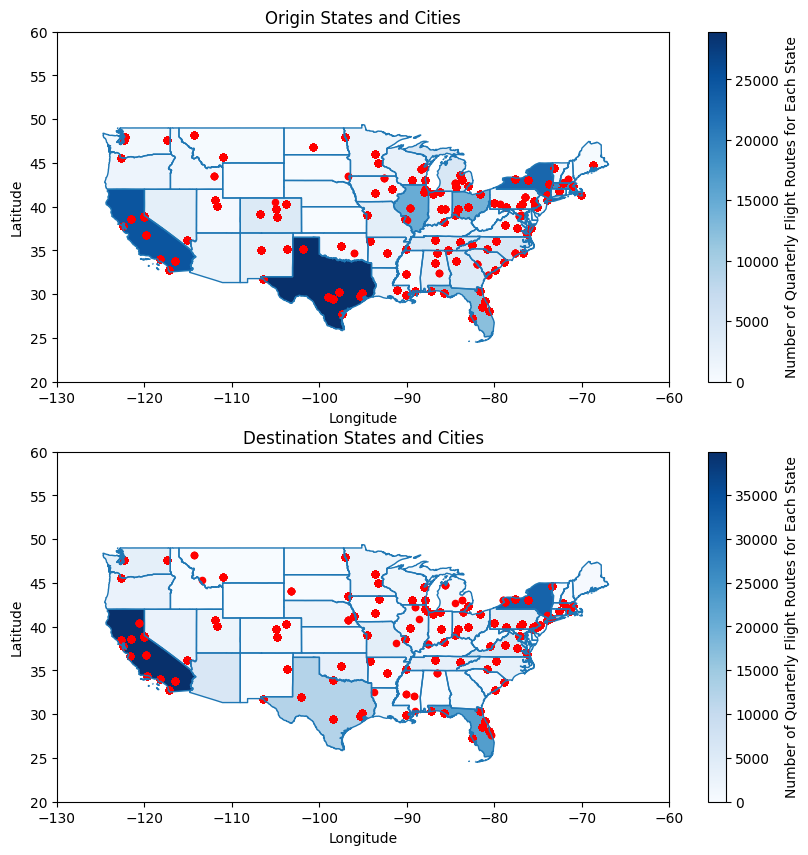

In [ ]:
# Calculate flight counts for origin states and destination states, then format as dataframes
state1_counts = df_train["state1"].value_counts().rename_axis("state").reset_index(name="counts1")
state2_counts = df_train["state2"].value_counts().rename_axis("state").reset_index(name="counts2")

# Merge flight counts into gdf_states for origin and destination states data
gdf_states = gdf_states.merge(state1_counts, how="left", left_on="STUSPS", right_on="state")
gdf_states = gdf_states.merge(state2_counts, how="left", left_on="STUSPS", right_on="state")
# Replace missing count values with 0 for states that do not have any flights
gdf_states.fillna({"counts1": 0, "counts2": 0}, inplace=True)

# Create geodataframes for origin and destination cities with point geometries from df_train
gdf_cities1 = gpd.GeoDataFrame(df_train, geometry=gpd.points_from_xy(df_train["lng1"], df_train["lat1"]))
gdf_cities2 = gpd.GeoDataFrame(df_train, geometry=gpd.points_from_xy(df_train["lng2"], df_train["lat2"]))

# Define a function to plot states and cities with flight counts on a map
def plot_map(gdf_states, gdf_cities, counts_col, title, ax):
  # Plot state boundaries
  gdf_states.boundary.plot(ax=ax, linewidth=1)
  # Plot states with color based on flight counts
  gdf_states.plot(column=counts_col, ax=ax, legend=True, legend_kwds={"label": "Number of Quarterly Flight Routes for Each State"}, cmap="Blues")
  gdf_cities.plot(ax=ax, markersize=20, color="red", label="Cities", legend=True)
  ax.set(title=title, xlabel="Longitude", ylabel="Latitude", xlim=(-130, -60), ylim=(20, 60))

fig, ax = plt.subplots(2, 1, figsize=(10, 10))
plot_map(gdf_states, gdf_cities1, "counts1", "Origin States and Cities", ax[0])
plot_map(gdf_states, gdf_cities2, "counts2", "Destination States and Cities", ax[1])
plt.show()

The two maps above show that California, Texas and New York are the major states that account for most flight routes. An interesting point to be noted is that while Texas does have a lot of flights going out of the state, there are not as many flights that come into it.

Visualize the trend of the demand over time

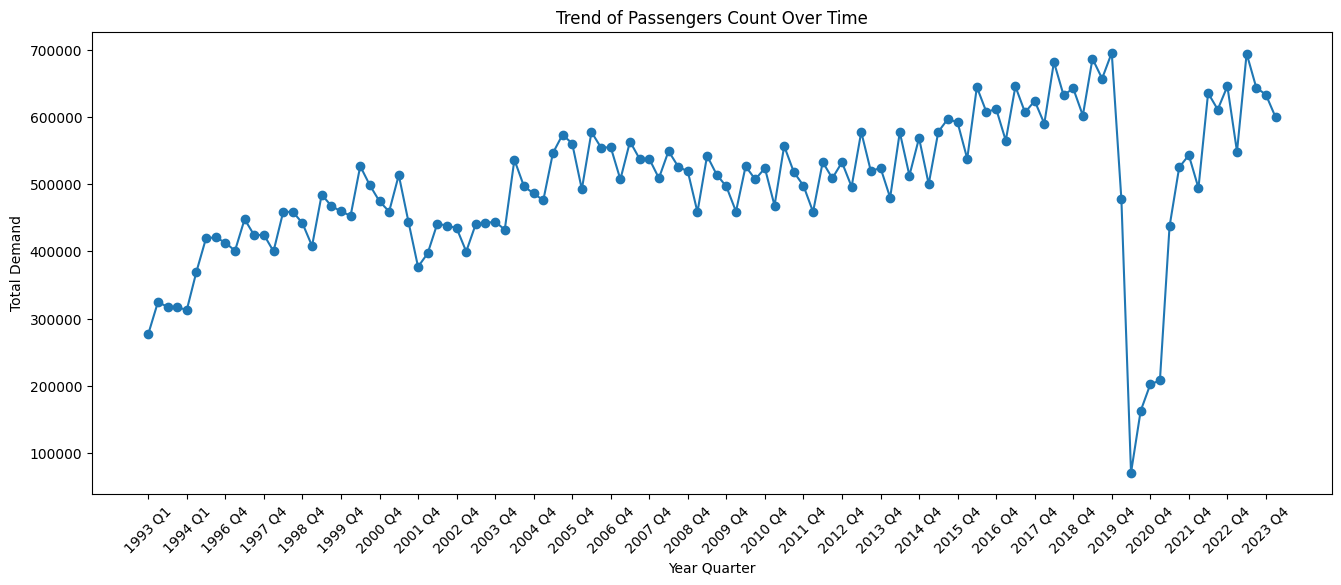

In [ ]:
df_train["year_quarter"] = df_train["year"].astype(str) + " Q" + df_train["quarter"].astype(str)
# df_train_encoded["year_quarter"] = pd.to_datetime(df_train_encoded["year_quarter"], format="%YQ%q")
demand_trend = df_train.groupby("year_quarter")["passengers_count"].sum().reset_index()

# Plot the demand trend over time
plt.figure(figsize=(16, 6))
plt.plot(demand_trend["year_quarter"], demand_trend["passengers_count"], marker="o")
plt.xlabel("Year Quarter")
plt.ylabel("Total Demand")
plt.xticks(ticks=range(0, len(demand_trend), 4), rotation=45)
plt.title("Trend of Passengers Count Over Time");

# Remove the column after visualization
df_train.drop("year_quarter", axis=1, inplace=True)

In [ ]:
display(df_train.head())
categorical_cols = ["quarter", "city1", "city2", "airport_1", "airport_2", "state1", "state2"]
unique_vals = df[categorical_cols].nunique()
display(unique_vals)

,year,quarter,city1,city2,airport_1,airport_2,distance,state1,state2,population1,population2,density1,density2,lat1,lng1,lat2,lng2,passengers_count
26156,2000,2,Boston,Miami,PVD,FLL,1284,MA,FL,215.0,81.0,42.3,56.0,42.358894,-71.056742,44.977479,-93.264346,342
18473,2004,4,Charlotte,San Francisco,CLT,SJC,2296,NC,CA,419.0,3364979.0,283.2,7030.7,35.222936,-80.840161,37.780080,-122.420168,112
193297,2016,3,Boston,Indianapolis,MHT,IND,818,MA,IN,215.0,1729849.0,42.3,941.8,42.358894,-71.056742,39.768450,-86.156212,31
245861,2024,1,New Orleans,Tampa,MSY,TPA,488,LA,FL,932759.0,131.0,866.5,99.4,29.950621,-90.074948,37.860600,-78.804199,548
12354,2003,3,Boston,Tampa,BOS,PIE,1204,MA,FL,215.0,131.0,42.3,99.4,42.358894,-71.056742,37.860600,-78.804199,0


,0
quarter,4
city1,139
city2,125
airport_1,187
airport_2,173
state1,44
state2,40


It can be observed that most categorical variables have high cardinality values. To avoid the curse of dimensionality and efficiently deal with missing values, we use target encoding to convert categorical variables to be numeric. One-hot encoding will still be used for the `quarter` column as it only has four different nominal values.

In [ ]:
df_train.head()

,year,quarter,city1,city2,airport_1,airport_2,distance,state1,state2,population1,population2,density1,density2,lat1,lng1,lat2,lng2,passengers_count
26156,2000,2,Boston,Miami,PVD,FLL,1284,MA,FL,215.0,81.0,42.3,56.0,42.358894,-71.056742,44.977479,-93.264346,342
18473,2004,4,Charlotte,San Francisco,CLT,SJC,2296,NC,CA,419.0,3364979.0,283.2,7030.7,35.222936,-80.840161,37.780080,-122.420168,112
193297,2016,3,Boston,Indianapolis,MHT,IND,818,MA,IN,215.0,1729849.0,42.3,941.8,42.358894,-71.056742,39.768450,-86.156212,31
245861,2024,1,New Orleans,Tampa,MSY,TPA,488,LA,FL,932759.0,131.0,866.5,99.4,29.950621,-90.074948,37.860600,-78.804199,548
12354,2003,3,Boston,Tampa,BOS,PIE,1204,MA,FL,215.0,131.0,42.3,99.4,42.358894,-71.056742,37.860600,-78.804199,0


In [ ]:
categorical_cols.remove("quarter") # Values in the "quarter" column are to be dealt using one-hot encoding later

# Initialize the encoder
encoder = TargetEncoder(cols=categorical_cols)

# Fit the encoder on the training data and transform both training and testing data
X_train_encoded = encoder.fit_transform(X_train, y_train)
X_test_encoded = encoder.transform(X_test)

# Convert 'quarter' into dummy variables
X_train_encoded = pd.get_dummies(X_train_encoded, columns=['quarter'])
X_test_encoded = pd.get_dummies(X_test_encoded, columns=['quarter'])

# Convert dummy variable columns into integer type
X_train_encoded = X_train_encoded.astype({col: "int" for col in X_train_encoded.columns if col.startswith("quarter_")})
X_test_encoded = X_test_encoded.astype({col: "int" for col in X_test_encoded.columns if col.startswith("quarter_")})

# Display the encoded dataframes
display(X_train_encoded.head())
display(X_test_encoded.head())

X_columns = X_train_encoded.columns # column names to be used later

,year,city1,city2,airport_1,airport_2,distance,state1,state2,population1,population2,density1,density2,lat1,lng1,lat2,lng2,quarter_1,quarter_2,quarter_3,quarter_4
26156,2000,291.423876,369.742385,129.012974,444.980834,1284,290.081683,396.298581,215.0,81.0,42.3,56.0,42.358894,-71.056742,44.977479,-93.264346,0,1,0,0
18473,2004,287.514296,407.348808,287.514296,275.680170,2296,232.817132,313.402699,419.0,3364979.0,283.2,7030.7,35.222936,-80.840161,37.780080,-122.420168,0,0,0,1
193297,2016,291.423876,192.124736,78.531970,192.124736,818,290.081683,181.701980,215.0,1729849.0,42.3,941.8,42.358894,-71.056742,39.768450,-86.156212,0,0,1,0
245861,2024,284.413142,370.655238,284.413142,431.050745,488,264.537992,396.298581,932759.0,131.0,866.5,99.4,29.950621,-90.074948,37.860600,-78.804199,1,0,0,0
12354,2003,291.423876,370.655238,650.403631,80.138583,1204,290.081683,396.298581,215.0,131.0,42.3,99.4,42.358894,-71.056742,37.860600,-78.804199,0,0,1,0


,year,city1,city2,airport_1,airport_2,distance,state1,state2,population1,population2,density1,density2,lat1,lng1,lat2,lng2,quarter_1,quarter_2,quarter_3,quarter_4
7350,2013,147.386520,220.147117,249.629297,706.348308,2073,153.438998,313.402699,119.0,430.0,48.3,450.8,41.505546,-81.691500,34.052238,-118.243344,0,0,0,1
131338,2000,51.796407,300.084003,51.796407,357.183869,437,94.160800,300.084003,40.0,54.0,140.8,153.4,39.962649,-82.996216,38.892062,-77.019912,0,1,0,0
137456,2003,342.878919,407.348808,274.016973,644.004559,372,360.864932,313.402699,430.0,3364979.0,450.8,7030.7,34.052238,-118.243344,37.780080,-122.420168,1,0,0,0
233170,2022,489.810043,220.147117,310.133132,40.235828,1750,489.210598,313.402699,8497759.0,430.0,4614.5,450.8,41.775002,-87.696388,34.052238,-118.243344,0,0,1,0
123706,2014,667.688608,665.398491,737.770759,665.855182,1107,580.365919,538.586974,1278.0,3561397.0,1064.3,3376.6,30.406931,-87.217578,47.603229,-122.330280,0,0,1,0


With all feature variables having numerical values, we can try visualizing a correlation matrix. As there might be nonlinear relationships between variables, this matrix will be simply used as a reference rather an than absolute criterion to judge whether certain features should be included or not.

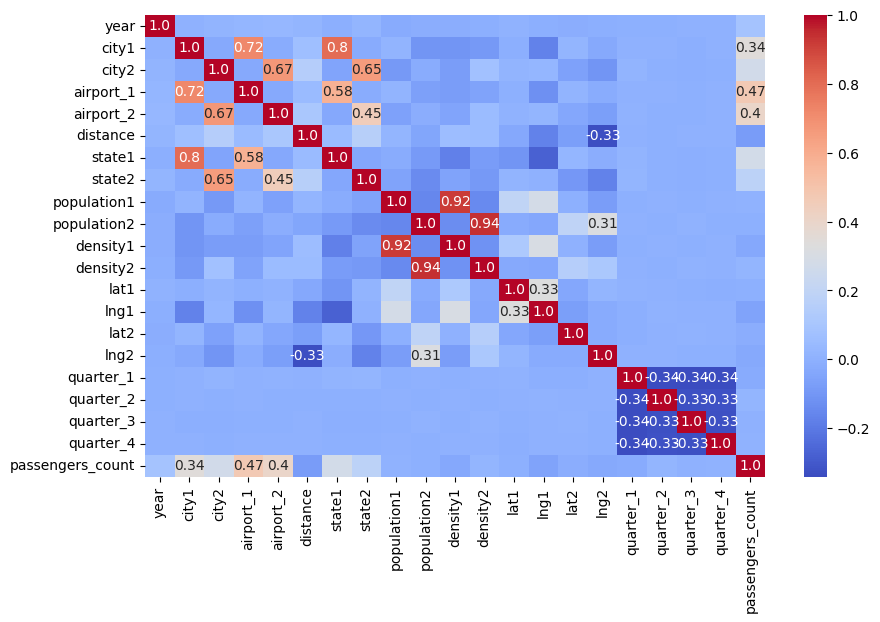

In [ ]:
# Merge the encoded training dataset
df_train_encoded = pd.concat([X_train_encoded, y_train], axis=1)

# Set the threshold for showing annotations
threshold = 0.3

# Create the correlation matrix
corr_matrix = df_train_encoded.corr()

# Create a custom annotation matrix where only correlations above the threshold are shown
annot = corr_matrix.where(corr_matrix.abs() >= threshold).round(2).astype(str)
annot = annot.where(corr_matrix.abs() >= threshold, "")  # Empty string for values below the threshold

# Plot the heatmap with the custom annotation matrix
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=annot, fmt="", cmap="coolwarm");

## Model Training and Selection

Before fitting and training any models, we should first standardize our data

In [ ]:
scaler = StandardScaler()
X_train_encoded = scaler.fit_transform(X_train_encoded)
X_test_encoded = scaler.transform(X_test_encoded)

Linear Regression with L1 Regularization:
<ul>
  <li>
    Higher interpretability: The results of a linear regression model is easier to interpret compared to other machine learning algorithms.
  </li>
  <li>
    Feature Selection: LassoCV can be particularly valuable in reducing the number of features in a model by setting coefficients of less important features to zero.
  </li>
  <li>
    Prevention of Overfitting: The L1 regularization helps prevent overfitting by constraining the size of the coefficients.
  </li>

In [ ]:
lasso_cv = LassoCV(cv=5, max_iter=10000)
lasso_cv.fit(X_train_encoded, y_train)

y_test_pred = lasso_cv.predict(X_test_encoded)

mse = mean_squared_error(y_test, y_test_pred)
r2 = r2_score(y_test, y_test_pred)
print("MSE:", mse)
print("R2:", r2)

MSE: 149048.08832917418
R2: 0.42807445267315614


Random Forest:
<ul>
  <li>
    Robustness: Random Forests are less prone to overfitting than many other algorithms because they average multiple deep decision trees, each trained on different parts of the same training set.
  </li>
  <li>
    Handling of Non-linear Relationships: Random Forests can handle non-linear relationships between features and the target variable without the need for transformations.
  </li>
  <li>
    Feature Handling: This algorithm can handle large data sets with higher dimensionality well; it can manage thousands of input variables without variable deletion, and it provides feature importance scores, which are helpful for understanding the factors driving predictions.
  </li>
  <li>
    Versatility: Works well with both numerical and categorical data and does not require scaling of data.
  </li>
</ul>

Due to the size and complexity of our dataset, RandomizedSearchCV was used to search for the optimal hyperparameters.

In [ ]:
rf = RandomForestRegressor()
param_distributions = {
    'n_estimators': np.arange(100, 200, 300),
    'max_features': ['log2', 'sqrt'],
    'max_depth': [10, 30, 50, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
rf_search = RandomizedSearchCV(estimator=rf, param_distributions=param_distributions, n_iter=10, cv=3, verbose=2, n_jobs=-1)
rf_search.fit(X_train_encoded, y_train)

y_test_pred = rf_search.predict(X_test_encoded)

mse = mean_squared_error(y_test, y_test_pred)
r2 = r2_score(y_test, y_test_pred)
print("MSE:", mse)
print("R2:", r2)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
MSE: 16387.98809429461
R2: 0.9371162074905951


Gradient Boosting:
<ul>
  <li>
    Performance: Often provides superior predictive accuracy thanks to its efficient handling of various data types and distributions. XGBoost is known for winning many machine learning competitions due to its effectiveness.
  </li>
  <li>
    Regularization: XGBoost includes built-in L1 and L2 regularization which helps prevent overfitting, which is crucial for high-dimensional data.
  </li>
  <li>
    Scalability: XGBoost is designed to be highly efficient, scalable, and fast, even over large datasets.
  </li>
</ul>

Due to the size and complexity of our dataset, RandomizedSearchCV was used to search for the optimal hyperparameters.

In [ ]:
xgb_model = xgb.XGBRegressor()
param_distributions = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 6, 9],
    'colsample_bytree': [0.5, 0.75, 1.0],
    'subsample': [0.6, 0.8, 1.0]
}
xgb_search = RandomizedSearchCV(estimator=xgb_model, param_distributions=param_distributions, n_iter=10, cv=3, verbose=2, random_state=42, n_jobs=-1)
xgb_search.fit(X_train_encoded, y_train)
y_test_pred = xgb_search.predict(X_test_encoded)
mse = mean_squared_error(y_test, y_test_pred)
r2 = r2_score(y_test, y_test_pred)
print("MSE:", mse)
print("R2:", r2)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
MSE: 5470.453042090961
R2: 0.9790088534355164


Neural Networks

In [ ]:
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_encoded.shape[1],), kernel_regularizer=tf.keras.regularizers.l1(0.01)),
    Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l1(0.01)),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Set TensorFlow to only allocate memory as needed
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f'Using GPU: {gpus}')
    except RuntimeError as e:
        print(e)
else:
    print("No GPU available, using CPU instead.")

history = model.fit(X_train_encoded, y_train, epochs=100, batch_size=32, validation_split=0.2)

Physical devices cannot be modified after being initialized
Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4920/4920 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - loss: 10371845120.0000 - val_loss: 7378892800.0000
Epoch 2/100
4920/4920 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - loss: 6527289856.0000 - val_loss: 6930135552.0000
Epoch 3/100
4920/4920 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step - loss: 5995217408.0000 - val_loss: 6648556032.0000
Epoch 4/100
4920/4920 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step - loss: 5764955648.0000 - val_loss: 6409509376.0000
Epoch 5/100
4920/4920 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - loss: 6075241472.0000 - val_loss: 6233472512.0000
Epoch 6/100
4920/4920 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - loss: 5685865472.0000 - val_loss: 6110521344.0000
Epoch 7/100
4920/4920 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - loss: 5655907840.0000 - val_loss: 5999070720.0000
Epoch 8/100
4920/4920 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - loss: 5316113920.0000 - val_loss: 5938827264.0000
Epoch 9/100
4920/4920 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - loss: 5274073088.0000 - val_loss: 5877624320.0000
Epoch 10/100
4920/4920 ━━━━━━━━━━━━━━━━

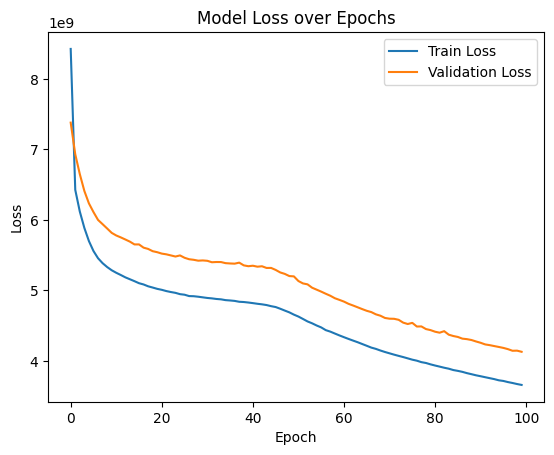

In [ ]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss over Epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [ ]:
y_test_pred = model.predict(X_test_encoded).flatten()
mse = mean_squared_error(y_test, y_test_pred)
r2 = r2_score(y_test, y_test_pred)
print("MSE:", mse)
print("R2:", r2)

1538/1538 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
MSE: 4137766567.398363
R2: 0.6764542284899852


Since Gradient Boosting has the highest performance results on the test set, we will be using this as the model to predict the number of daily passengers for particular routes.

Save the preprocessors and the model so that it can be later used as a part of the optimization process

In [ ]:
# Dump the encoder preprocessor
dump(encoder, "fitted_encoder.joblib")

# Dump the scaler preprocessor
dump(scaler, "fitted_scaler.joblib")

# Dump the model
dump(xgb_search, "fitted_xgb_model.joblib")

['fitted_xgb_model.joblib']

In [ ]:
routes = df.drop(["year", "quarter", "passengers_count"], axis=1)
routes.drop_duplicates(inplace=True)
routes.reset_index(drop=True, inplace=True)
routes.to_csv("routes_data.csv")